In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import graphviz

In [15]:
data_raw_full = pd.read_csv('nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)
data_raw = data_raw_full[['ID','w1WEIGHT_ADJ', 'w2DECEASED', 'w3DECEASED',
                          'w1AGE', 'w1SYSTOLIC_MEAN',
                          'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                          'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                          'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                          'w1GENDER',
                          'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
data_raw.head(n=5)


,ID,w1WEIGHT_ADJ,w2DECEASED,w3DECEASED,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1DHEA_1,...,w1HRSSLEEP,w1EDUC,w1HSASSETS_RECODE,w1MARITLST,w1ETHGRP,w1GENDER,w1PHYSHLTH,w1MNTLHLTH,w1CONDITNS_3,w1WALKBLK
0,100005,0.846541,0.0,0.0,62.0,113.5,30.248745,5.5,11.746,19.400000,...,6.0,4.0,4.0,1.0,1.0,2.0,4.0,4.0,0.0,0.0
1,100033,0.649874,0.0,0.0,79.0,114.0,44.103840,6.6,2.922,32.349998,...,5.0,3.0,4.0,5.0,1.0,2.0,4.0,4.0,0.0,3.0
2,100067,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100080,1.193744,0.0,0.0,60.0,126.5,37.678516,7.3,0.552,19.990000,...,5.0,3.0,5.0,1.0,1.0,1.0,3.0,5.0,0.0,0.0
4,100149,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning

In [9]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
print("{} respondents with W1 observations".format(len(data_w1)))

data_decease= data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))


Total observations: 6069
Removed follow-up 3064 respondents without W1 observations
3005 respondents with W1 observations
Removed follow-up 10 respondents without disposition statuses
Sample frame has 2995 respondents


In [10]:
data_complete['deceased'].value_counts()

0.0    2102
1.0     893
Name: deceased, dtype: int64

In [11]:
data = data_complete[['ID','deceased', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]

In [17]:
data.head(n=8)

,ID,deceased,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1DHEA_1,w1DHEA_2,w1SMOKECIG,...,w1HRSSLEEP,w1EDUC,w1HSASSETS_RECODE,w1MARITLST,w1ETHGRP,w1GENDER,w1PHYSHLTH,w1MNTLHLTH,w1CONDITNS_3,w1WALKBLK
0,100005,0.0,62.0,113.500000,30.248745,5.5,11.746,19.400000,16.139999,0.0,...,6.0,4.0,4.0,1.0,1.0,2.0,4.0,4.0,0.0,0.0
1,100033,0.0,79.0,114.000000,44.103840,6.6,2.922,32.349998,36.209999,0.0,...,5.0,3.0,4.0,5.0,1.0,2.0,4.0,4.0,0.0,3.0
3,100080,0.0,60.0,126.500000,37.678516,7.3,0.552,19.990000,22.280001,0.0,...,5.0,3.0,5.0,1.0,1.0,1.0,3.0,5.0,0.0,0.0
5,100154,0.0,78.0,176.000000,25.401367,5.7,0.499,27.510000,29.559999,0.0,...,5.0,2.0,-2.0,1.0,1.0,2.0,3.0,3.0,0.0,0.0
7,100203,0.0,61.0,137.666672,27.895041,-3.0,-3.000,57.250000,57.250000,0.0,...,7.0,1.0,1.0,5.0,3.0,2.0,1.0,2.0,0.0,1.0
9,100359,1.0,75.0,156.500000,26.143854,-3.0,-3.000,11.560000,10.330000,0.0,...,8.0,3.0,5.0,1.0,1.0,1.0,2.0,3.0,0.0,0.0
11,100392,1.0,80.0,129.500000,-3.000000,-3.0,-3.000,38.990002,37.900002,0.0,...,7.0,3.0,4.0,5.0,1.0,1.0,3.0,3.0,0.0,0.0
15,100476,0.0,72.0,152.000000,30.761475,6.0,0.801,20.540001,17.420000,0.0,...,9.0,2.0,5.0,1.0,1.0,1.0,3.0,5.0,0.0,0.0


In [7]:
# Preprocessing binary variables
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1MARITLST',
           'w1ETHGRP', 'w1GENDER',
           'w1CONDITNS_3']
data_cat = data[data[cat_col].notnull()].copy()[cat_col]    
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 'Married', 1, 0)
data_cat['w1raceblk'] = np.where(data_cat['w1ETHGRP'] == 'Married', 1, 0)
data_cat.drop('w1MARITLST', axis=1, inplace=True)
data_cat.drop('w1ETHGRP', axis=1, inplace=True)

In [18]:
# Preprocessing ordinal variables
ord_col = ['w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]
data_ord[data_ord < 0] = np.nan
data_ord_na = data_ord.dropna()
print("Fixed {} respondents with missing continuous variables".format(len(data_ord) - len(data_ord_na)))
data_ord.fillna(data_ord.mean(), inplace=True)

Fixed 1155 respondents with missing continuous variables


In [9]:
# Preprocessing continuous variables
con_col = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP']
data_con = data[data[con_col].notnull()].copy()[con_col]    
for col in con_col:
    data_con[col] = pd.to_numeric(data_con[col], errors='coerce')
data_con['w1dhea_mean'] = data_con[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_con = data_con.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_con[data_con < 0] = np.nan
data_con.fillna(data_con.mean(), inplace=True)
data_con.describe()

,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,69.307513,137.138234,29.095167,6.097641,3.194580,6.888366,52.921454
std,7.857698,20.306078,6.078190,0.782456,4.848129,1.381350,109.835482
min,57.000000,78.000000,14.063041,4.200000,0.000000,1.000000,1.510000
25%,62.000000,122.500000,25.101870,5.700000,1.053500,6.000000,22.252500
50%,69.000000,135.666672,28.793165,6.097641,3.194580,7.000000,46.205000
75%,76.000000,149.000000,31.773318,6.097641,3.194580,8.000000,53.247500
max,85.000000,233.000000,75.600655,14.200000,100.000000,13.000000,5000.000000


In [10]:
data = pd.concat([data_cat, data_ord, data_con], axis=1)
data_nona = data.dropna()
print("Removed {} respondents with missing values in categorical variables".\
    format(len(data) - len(data_nona)))

Removed 0 respondents with missing values in categorical variables


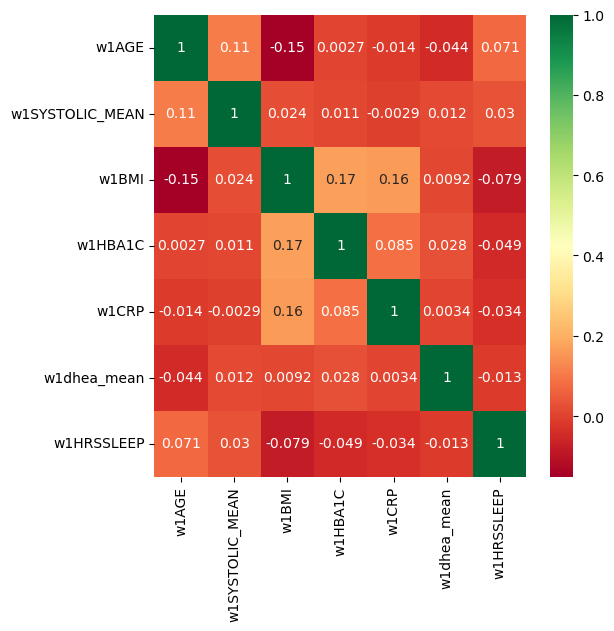

In [11]:
_, ax = plt.subplots(figsize=(6,6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1dhea_mean', 'w1HRSSLEEP']
sns.heatmap(data[columns].corr(),annot=True,cmap='RdYlGn', ax=ax);

## Decision Tree

In [12]:

data_x = data_nona[['w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1dhea_mean',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1married', 'w1raceblk',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
predictor_names = ['Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP', 'DHEA',
                   'smoker', 'alcohol', 'physical activity', 'sleep',
                   'education', 'wealth', 'married', 'black race', 'gender',
                   'physical self-rated health', 'mental self-rated health',
                   'chronic conditions', 'walking 1 block']
data_y = data_nona[['deceased']]

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42)
 # 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

In [13]:
# BOTH PRE-PRUNING AND POST_PRUNING (PYTHON PACKAGES TO AUTOMATE THIS PROCESS)
DT_clf = tree.DecisionTreeClassifier(random_state=42, criterion="entropy", 
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       random_state=42)

In [14]:
# save tree to iris.pdf
dot_data = tree.export_graphviz(DT_clf, out_file=None,
                                feature_names=predictor_names,
                                class_names=['alive', 'deceased']) 
graph = graphviz.Source(dot_data) 
graph.render("dt_nshap") 

'dt_nshap.pdf'

In [15]:
DT_clf.score(X_test, y_test)

0.7378964941569283

## Random Forest

In [16]:
RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(X_train,y_train)

/var/folders/6y/yk_wztl52kv6qrddmxlbm2_c0000gn/T/ipykernel_92405/2945712927.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train,y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [17]:
RF_clf.score(X_test, y_test)

0.7195325542570952

In [20]:
dot_data = tree.export_graphviz(RF_clf.estimators_[0], out_file=None, 
                                filled=True, rounded=True,  
                                special_characters=True,
                                feature_names=predictor_names,
                                class_names=['Alive', 'Deceased'])  
graph = graphviz.Source(dot_data)  
graph.render("rf_nshap")

'rf_nshap.pdf'